# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import ParameterGrid
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import datasets
from weighted_random_search import wrs
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import import_ipynb
from CNNpy import CNN_3_class

# Classes

In [4]:
class Net_wrapper:
    """ 
    Wrapper for neural network model. It combines the model itself (nn.Module) together with
    optimizer, loss function and training parameters (such as max_epochs, learning rate and batch size)
    """
        
    def __init__(self, model=CNN_3_class, criterion=nn.CrossEntropyLoss(), optimizer=optim.Adam, weight_decay = 0,
                 max_epochs=5, batch_size=32, learning_rate=0.001, step_size=10, gamma=0.5, **kwargs):
        if kwargs:
            self.model_params = kwargs
        else:
            self.model_params = {}
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.scheduler_step_size=step_size
        self.scheduler_gamma=gamma
        self.weight_decay = weight_decay
    
    def __setattr__(self, name, value):
        self.__dict__[name] = value

    def score(self, train_dataset, val_dataset, verbose=0):
        """
        Train model on train_dataset and calculate validation acurracy on val_dataset. 
        """
        if self.model_params:
            model = self.model(**self.model_params)
            
        else:
            model = self.model()
        
        optimizer = self.optimizer(model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = StepLR(optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        
        # TRAINING LOOP
        for epoch in range(self.max_epochs):
            
            if verbose == 1:
                print(f'Epoch {epoch+1}/{self.max_epochs}')
                t_loader = tqdm(train_loader)
                v_loader = tqdm(val_loader)
            else:
                t_loader = train_loader
                v_loader = val_loader
           
           # Train the model
            avg_train_accuracy = 0
            avg_train_loss = 0
            
            for x, y in t_loader:
                optimizer.zero_grad()

                output = model(x)
                train_loss = self.criterion(output, y)
                train_loss.backward()
                optimizer.step()

                train_accuracy = (output.argmax(dim=1) == y).float().mean()

                avg_train_accuracy += train_accuracy.item()
                avg_train_loss += train_loss.item()
            
            # Calculate average training loss and accuracy for the epoch
            avg_train_accuracy = avg_train_accuracy / len(train_loader)
            avg_train_loss = avg_train_loss / len(train_loader)
            
            if verbose == 1:
                print(f'train_acc:{avg_train_accuracy}, train_loss: {avg_train_loss}')

            # Test the model
            avg_val_loss = 0
            avg_val_accuracy = 0
            
            with torch.no_grad():
                for x, y in v_loader:
                    output = model(x)
                    val_loss = self.criterion(output, y)
                    val_accuracy = (output.argmax(dim=1) == y).float().mean()
                    avg_val_loss += val_loss.item()
                    avg_val_accuracy += val_accuracy.item()

            # Calculate average test loss and accuracy for the epoch
            avg_val_accuracy = avg_val_accuracy / len(val_loader)
            avg_val_loss = avg_val_loss / len(val_loader)

            if verbose == 1:
                print(f'val_acc:{avg_val_accuracy}, val_loss: {avg_val_loss}')

            scheduler.step()

        return avg_train_accuracy, avg_train_loss, avg_val_accuracy, avg_val_loss
        
    

In [5]:
class RandomSearch:
    
    def __init__(self, net: Net_wrapper, param_grid, verbose=1):
      """

      """
      self.net = net
      self.param_grid = param_grid
      self.scores = []
      self.best_score = 0
      self.best_params = {}
      self.verbose = verbose

     
    @staticmethod
    def choose_random__params(parameters, seed=1):
      random_params = {}
      rnd = np.random.RandomState(seed)
      
      for param in parameters:

        if isinstance(parameters[param][0], float):
          random_params[param] = rnd.uniform(low=parameters[param][0], high=parameters[param][1])
        elif isinstance(parameters[param][0], int):
          random_params[param] = rnd.randint(low=parameters[param][0], high=parameters[param][1])
        else:
          random_params[param] = parameters[param][rnd.randint(0, len(parameters[param]))]
      
      return random_params

      
    def fit(self, train_dataset, val_dataset, n_trials = 10):
      """
      Fit the grid search with train and validation dataset. 
      Search for optimal parameters for neural network declared during 
      initialization of GridSearch instance.
      """
      
      for trial in range(n_trials):
          random_params = RandomSearch.choose_random__params(parameters=self.param_grid, seed=trial)
          for hyp_name, hyp_val in random_params.items():
              if hasattr(self.net, hyp_name):
                  setattr(self.net, hyp_name, hyp_val)
              else:
                  self.net.model_params[hyp_name] = hyp_val

          _, _, val_accuracy, _ = self.net.score(train_dataset, val_dataset)
          self.scores.append(val_accuracy)
          if val_accuracy > self.best_score:
              self.best_score = val_accuracy
              self.best_params = random_params
          if self.verbose == 1:
              print('Parameter set:', random_params)
              print(f'val_accuracy: {val_accuracy:.4f}')

      return self


In [6]:
class GridSearch:
    """
    Class used to perform grid search on neural networks 

    Attributes:
    self.net - Net_wrapper instance
    self.param_grid - dictionary of parameters we want to search
    self.scores - list for scores of each set of parameters
    self.best_score - best score out of all parameters
    self.best_params - best set of parameters
    self.verbose - if set to 1 additional information (parameter set and accuracy) prints with each iteration of grid search. 
    """
    def __init__(self, net: Net_wrapper, param_grid, step_by_step=False, verbose=1):
        """

        """
        self.net = net
        self.param_grid = param_grid
        self.scores = []
        self.best_score = 0
        self.best_params = {}
        self.step_by_step = step_by_step
        self.verbose = verbose


    def fit(self, train_dataset, val_dataset):
        """
        Fit the grid search with train and validation dataset. 
        Search for optimal parameters for neural network declared during 
        initialization of GridSearch instance.
        """
        if self.step_by_step==False:
            for params in ParameterGrid(self.param_grid):
                for hyp_name, hyp_val in params.items():
                    if hasattr(self.net, hyp_name):
                        setattr(self.net, hyp_name, hyp_val)
                    else:
                        self.net.model_params[hyp_name] = hyp_val

                _, _, val_accuracy, _ = self.net.score(train_dataset, val_dataset)
                self.scores.append(val_accuracy)
                if val_accuracy > self.best_score:
                    self.best_score = val_accuracy
                    self.best_params = params
                if self.verbose == 1:
                    print('Parameter set:', params)
                    print(f'val_accuracy: {val_accuracy:.4f}')
        else:
            
            for hyp_name, hyp_vals in self.param_grid.items():
                score = 0
                for hyp_val in hyp_vals:
                    if hasattr(self.net, hyp_name):
                        setattr(self.net, hyp_name, hyp_val)
                    else:
                        self.net.model_params[hyp_name] = hyp_val 

                    _, _, val_accuracy, _ = self.net.score(train_dataset, val_dataset)
                    self.scores.append(val_accuracy)
                    
                    if val_accuracy > score:
                        if score > self.best_score:
                            self.best_score = score
                        score = val_accuracy
                        self.best_params[hyp_name] = hyp_val
                    
                    if self.verbose == 1:
                        print(f'Current parameter: {hyp_name}:', hyp_val, f'  val_accuracy: {val_accuracy:.4f}')
                        print(f'Best parameters till now:{self.best_params}')
                
                if hasattr(self.net, hyp_name):
                    setattr(self.net, hyp_name, self.best_params[hyp_name])
                    print(getattr(self.net, hyp_name))
                else:
                    self.net.model_params[hyp_name] = self.best_params[hyp_name]

        return self

In [7]:
class WeightedRandomSearch():
    """
    Class used to perform grid search on neural networks 

    Attributes:
    self.net - Net_wrapper instance
    self.param_grid - dictionary of parameters we want to search
    self.scores - list for scores of each set of parameters
    self.best_score - best score out of all parameters
    self.best_params - best set of parameters
    self.verbose - if set to 1 additional information (parameter set and accuracy) prints with each iteration of grid search. 
    """
    def __init__(self, net, param_grid, verbose=1):
        """

        """
        self.net = net
        self.param_grid = param_grid
        self.scores = []
        self.best_score = 0
        self.best_params = None
        self.verbose = verbose

    def fit(self, train_dataset, val_dataset, N, N_0):
        """
        Fit the grid search with train and validation dataset. 
        Search for optimal parameters for neural network declared during 
        initialization of GridSearch instance.
        """
        def goal_function(params):
            
            for hyp_name, hyp_val in params.items():
                if hasattr(self.net, hyp_name):
                    setattr(self.net, hyp_name, hyp_val)
                else:
                    self.net.model_params[hyp_name] = hyp_val
            
            return self.net.score(train_dataset, val_dataset)[1]
            
        self.best_params, self.best_score = wrs(F=goal_function, N=N, N_0=N_0, param_grid=self.param_grid )
        
        return self

### Example hyperparameters (from most to least important):

In [8]:
hyperparams1 = {'learning_rate': [0.001, 0.005, 0.01],
               'batch_size': [8, 32, 64],
               'max_epochs': [5, 10, 15]}

hyperparams2 = {
                'no_neurons': [25, 50, 100],
                'kernel_size': [2, 3, 5],
                'number_of_filters': [16, 32, 64]
                }

hyperparams3 = {
               'optimizer': [optim.Adam, optim.Adagrad, optim.SGD],
               'activation_func': [nn.ReLU, nn.LeakyReLU, nn.Tanh],
               'dropout_rate': [0.0, 0.25, 0.5]}



### Sample for testing GridSearch

In [9]:
train_dataset = datasets.cifar_train
val_dataset = datasets.cifar_val

In [10]:
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset

subset_indices = list(range(500))
subset_sampler = SubsetRandomSampler(subset_indices)

subset_train_dataset = Subset(train_dataset, subset_indices)
subset_val_dataset = Subset(val_dataset, subset_indices)

### GridSearch / RandomSearch test

In [14]:
test_hyper_params = {'learning_rate': [0.0001, 0.0005, 0.001, 0.005], 'batch_size': [8, 16, 32, 64]}#, 'kernel_size1': [3, 4, 8]}
my_net = Net_wrapper(model=CNN_3_class, optimizer=optim.Adam, max_epochs=5, learning_rate=0.0005, batch_size=8, 
                     number_of_filters0=32, number_of_filters1=256, no_neurons=500)
gs = GridSearch(net=my_net, param_grid=test_hyper_params, step_by_step=True, verbose=1)
# gs = gs.fit(subset_train_dataset, subset_val_dataset)
gs = gs.fit(train_dataset, val_dataset)

RuntimeError: shape '[-1, 18496]' is invalid for input of size 131072

In [13]:
print(gs.best_score)
print(gs.best_params)

0.3333333333333333
{'learning_rate': 0.0005, 'batch_size': 16}


In [14]:
test_hyper_params = {'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1], 'batch_size': [8, 16, 32, 64, 128]}
rs = RandomSearch(my_net, test_hyper_params, verbose=1)
rs.fit(subset_train_dataset, subset_val_dataset, n_trials = 5)

Parameter set: {'learning_rate': 0.0003195254015709299, 'batch_size': 13}
val_accuracy: 0.3353
Parameter set: {'learning_rate': 0.0002668088018810296, 'batch_size': 12}
val_accuracy: 0.3552
Parameter set: {'learning_rate': 0.0002743979608568015, 'batch_size': 13}
val_accuracy: 0.3478
Parameter set: {'learning_rate': 0.0003203191610298302, 'batch_size': 9}
val_accuracy: 0.3448
Parameter set: {'learning_rate': 0.0004868119356054707, 'batch_size': 15}
val_accuracy: 0.3510


In [15]:
print(rs.best_score)
print(rs.best_params)

0.35515872903522994
{'learning_rate': 0.0002668088018810296, 'batch_size': 12}


### Weighted random search test

In [28]:
my_net = Net_wrapper()
param_grid = {'lr': [0.01, 0.05, 0.1, 0.5, 1, 2], 'batch_size': [16, 32, 64, 128, 256]}
w = WeightedRandomSearch(net=my_net, param_grid=test_hyper_params)
N, N_0 = 10, 3
w.fit(subset_train_dataset, subset_val_dataset, N, N_0)
print(w.best_params)

{'learning_rate': 0.01, 'batch_size': 64, 'no_neurons': 64} 0.11944110598415136
{'learning_rate': 0.005, 'batch_size': 64, 'no_neurons': 64} 0.28305288404226303
{'learning_rate': 0.005, 'batch_size': 64, 'no_neurons': 64} 0.28305288404226303
{'learning_rate': 0.005, 'batch_size': 64, 'no_neurons': 64} 0.28305288404226303
{'learning_rate': 0.005, 'batch_size': 64, 'no_neurons': 64} 0.28305288404226303
{'learning_rate': 0.005, 'batch_size': 64, 'no_neurons': 64} 0.28305288404226303
{'learning_rate': 0.005, 'batch_size': 64, 'no_neurons': 64} 0.28305288404226303
{'learning_rate': 0.005, 'batch_size': 64, 'no_neurons': 64} 0.28305288404226303
{'learning_rate': 0.005, 'batch_size': 64, 'no_neurons': 64} 0.28305288404226303
{'learning_rate': 0.005, 'batch_size': 64, 'no_neurons': 64} 0.28305288404226303
{'learning_rate': 0.005, 'batch_size': 64, 'no_neurons': 64} 0.28305288404226303


# Hyperparameter Tuning

## CNN_3_class on original dataset (without augmentation)

1. Learning rate + batch size

In [16]:
my_net = Net_wrapper(model=CNN_3_class, max_epochs=5)
param_grid = {'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01], 'batch_size': [8, 16, 32, 64, 128]}
gs = GridSearch(net=my_net, param_grid=param_grid, step_by_step=True, verbose=1)
gs = gs.fit(train_dataset, val_dataset)

Current parameter: learning_rate: 0.0001   val_accuracy: 0.5830
Best parameters till now:{'learning_rate': 0.0001}
Current parameter: learning_rate: 0.0005   val_accuracy: 0.6887
Best parameters till now:{'learning_rate': 0.0005}
Current parameter: learning_rate: 0.001   val_accuracy: 0.6761
Best parameters till now:{'learning_rate': 0.0005}
Current parameter: learning_rate: 0.005   val_accuracy: 0.5991
Best parameters till now:{'learning_rate': 0.0005}
Current parameter: learning_rate: 0.01   val_accuracy: 0.1000
Best parameters till now:{'learning_rate': 0.0005}
0.0005
Current parameter: batch_size: 8   val_accuracy: 0.6954
Best parameters till now:{'learning_rate': 0.0005, 'batch_size': 8}
Current parameter: batch_size: 16   val_accuracy: 0.6823
Best parameters till now:{'learning_rate': 0.0005, 'batch_size': 8}
Current parameter: batch_size: 32   val_accuracy: 0.6785
Best parameters till now:{'learning_rate': 0.0005, 'batch_size': 8}
Current parameter: batch_size: 64   val_accuracy

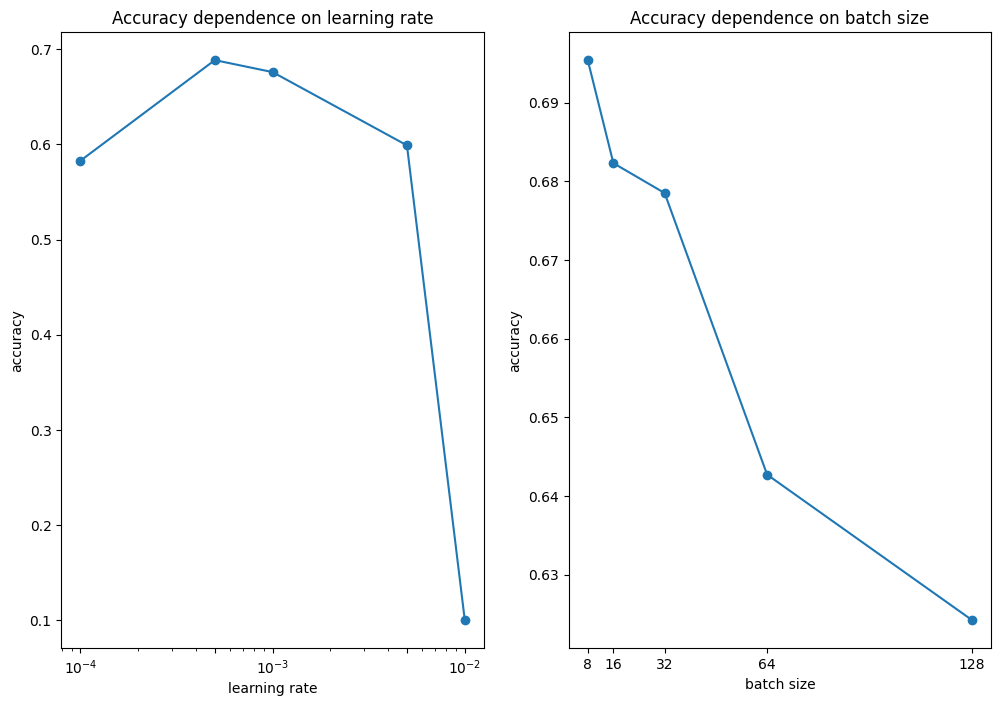

In [21]:
param_grid = {'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01], 'batch_size': [8, 16, 32, 64, 128]}
learning_rate = [0.583, 0.6887, 0.6761, 0.5991, 0.1]
batch_size = [0.6954, 0.6823, 0.6785, 0.6427, 0.6242]

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].plot(param_grid['learning_rate'], learning_rate, marker='o')
ax[0].set_title("Accuracy dependence on learning rate")
ax[0].set_xlabel("learning rate")
ax[0].set_ylabel("accuracy")
ax[0].set_xscale("log")
ax[0].set_xticks(param_grid['learning_rate'])
ax[1].plot(param_grid['batch_size'], batch_size, marker = 'o')
ax[1].set_title("Accuracy dependence on batch size")
ax[1].set_xlabel("batch size")
ax[1].set_ylabel("accuracy")
ax[1].set_ylim((0.5, 1))
ax[1].set_xticks(param_grid['batch_size'])
plt.show()

2. Dropout, weight_decay

In [20]:
my_net = Net_wrapper(model=CNN_3_class, max_epochs=5, learning_rate=0.0005, batch_size=8)
param_grid = {'dr': [nn.Dropout(0), nn.Dropout(0.1), nn.Dropout(0.25), nn.Dropout(0.4), nn.Dropout(0.5)], 'weight_decay': [0, 1e-5, 1e-4, 1e-3]}
gs = GridSearch(net=my_net, param_grid=param_grid, step_by_step=True, verbose=1)
gs = gs.fit(train_dataset, val_dataset)

Current parameter: dr: Dropout(p=0, inplace=False)   val_accuracy: 0.7061
Best parameters till now:{'dr': Dropout(p=0, inplace=False)}
Current parameter: dr: Dropout(p=0.1, inplace=False)   val_accuracy: 0.6770
Best parameters till now:{'dr': Dropout(p=0, inplace=False)}
Current parameter: dr: Dropout(p=0.25, inplace=False)   val_accuracy: 0.6614
Best parameters till now:{'dr': Dropout(p=0, inplace=False)}
Current parameter: dr: Dropout(p=0.4, inplace=False)   val_accuracy: 0.6550
Best parameters till now:{'dr': Dropout(p=0, inplace=False)}
Current parameter: dr: Dropout(p=0.5, inplace=False)   val_accuracy: 0.6351
Best parameters till now:{'dr': Dropout(p=0, inplace=False)}
Current parameter: weight_decay: 0   val_accuracy: 0.7047
Best parameters till now:{'dr': Dropout(p=0, inplace=False), 'weight_decay': 0}
Current parameter: weight_decay: 1e-05   val_accuracy: 0.6925
Best parameters till now:{'dr': Dropout(p=0, inplace=False), 'weight_decay': 0}
Current parameter: weight_decay: 0.0

3. Net architecture (kernel size, number of filters)

In [10]:
my_net = Net_wrapper(model=CNN_3_class, max_epochs=5, learning_rate=0.0005, batch_size=8)
param_grid = {'number_of_filters0': [32, 64, 128, 256], 'number_of_filters1': [32, 64, 128, 256]}
gs = GridSearch(net=my_net, param_grid=param_grid, step_by_step=True, verbose=1)
gs = gs.fit(train_dataset, val_dataset)

Current parameter: number_of_filters0: 32   val_accuracy: 0.7007
Best parameters till now:{'number_of_filters0': 32}
Current parameter: number_of_filters0: 64   val_accuracy: 0.6869
Best parameters till now:{'number_of_filters0': 32}
Current parameter: number_of_filters0: 128   val_accuracy: 0.7005
Best parameters till now:{'number_of_filters0': 32}
Current parameter: number_of_filters0: 256   val_accuracy: 0.6403
Best parameters till now:{'number_of_filters0': 32}
Current parameter: number_of_filters1: 32   val_accuracy: 0.6976
Best parameters till now:{'number_of_filters0': 32, 'number_of_filters1': 32}
Current parameter: number_of_filters1: 64   val_accuracy: 0.7197
Best parameters till now:{'number_of_filters0': 32, 'number_of_filters1': 64}
Current parameter: number_of_filters1: 128   val_accuracy: 0.7115
Best parameters till now:{'number_of_filters0': 32, 'number_of_filters1': 64}
Current parameter: number_of_filters1: 256   val_accuracy: 0.7270
Best parameters till now:{'number_

TypeError: CNN_3_class.__init__() got an unexpected keyword argument 'kernel_size1'

In [ ]:
filter0 = [0.7007, 0.6869, 0.7005, 0.6403]
filter1 = [0.6976, 0.7197, 0.7115, 0.727]

In [19]:
my_net = Net_wrapper(model=CNN_3_class, max_epochs=5, learning_rate=0.0005, batch_size=8, 
                     number_of_filters0=32, number_of_filters1=256)
param_grid = {'kernel_size1': [3,4,5], 'kernel_size2':[3,4,5], 'no_neurons': [32, 64, 128, 256]}
gs = GridSearch(net=my_net, param_grid=param_grid, step_by_step=True, verbose=1)
gs = gs.fit(train_dataset, val_dataset)

4. Num of epochs (run a lot of epochs and stop when validation accuracy starts to decrease)

In [43]:
my_net = Net_wrapper(model=CNN_3_class, max_epochs=20, learning_rate=0.0005, batch_size=8, verbose=1)
my_net.score(train_dataset, val_dataset)

Epoch 1/20


100%|██████████| 5000/5000 [02:22<00:00, 35.16it/s]


train_loss:1.367179244017601, train_acc: 0.5074


100%|██████████| 1250/1250 [00:19<00:00, 62.74it/s]


val_loss:1.1311261782169342, val_acc: 0.6056
Epoch 2/20


100%|██████████| 5000/5000 [02:23<00:00, 34.88it/s]


train_loss:1.0221099519059063, train_acc: 0.637175


100%|██████████| 1250/1250 [00:18<00:00, 66.59it/s]


val_loss:0.993101014137268, val_acc: 0.6527
Epoch 3/20


100%|██████████| 5000/5000 [02:30<00:00, 33.33it/s]


train_loss:0.8751001523837447, train_acc: 0.690425


100%|██████████| 1250/1250 [00:21<00:00, 58.75it/s]


val_loss:0.9432699997067452, val_acc: 0.6715
Epoch 4/20


100%|██████████| 5000/5000 [02:15<00:00, 37.02it/s]


train_loss:0.7678421761438251, train_acc: 0.73045


100%|██████████| 1250/1250 [00:16<00:00, 73.90it/s]


val_loss:0.901851232546568, val_acc: 0.6923
Epoch 5/20


100%|██████████| 5000/5000 [02:03<00:00, 40.53it/s]


train_loss:0.6812195054091513, train_acc: 0.76025


100%|██████████| 1250/1250 [00:17<00:00, 70.63it/s]


val_loss:0.8833921184927225, val_acc: 0.6964
Epoch 6/20


100%|██████████| 5000/5000 [02:06<00:00, 39.62it/s]


train_loss:0.6047580602146685, train_acc: 0.7869


100%|██████████| 1250/1250 [00:18<00:00, 69.33it/s]


val_loss:0.9163684277355671, val_acc: 0.6984
Epoch 7/20


100%|██████████| 5000/5000 [02:24<00:00, 34.71it/s]


train_loss:0.5349723679063841, train_acc: 0.8111


100%|██████████| 1250/1250 [00:17<00:00, 73.16it/s]


val_loss:0.9288069393068552, val_acc: 0.7
Epoch 8/20


100%|██████████| 5000/5000 [02:08<00:00, 38.93it/s]


train_loss:0.46668085316661745, train_acc: 0.836475


100%|██████████| 1250/1250 [00:16<00:00, 74.35it/s]


val_loss:0.9727133320122957, val_acc: 0.7042
Epoch 9/20


100%|██████████| 5000/5000 [02:14<00:00, 37.22it/s]


train_loss:0.40310598198021763, train_acc: 0.859075


100%|██████████| 1250/1250 [00:16<00:00, 75.02it/s]


val_loss:1.0612843801558018, val_acc: 0.6872
Epoch 10/20


100%|██████████| 5000/5000 [02:31<00:00, 32.94it/s]


train_loss:0.34871114134127273, train_acc: 0.87725


100%|██████████| 1250/1250 [00:27<00:00, 45.46it/s]


val_loss:1.1207977756097913, val_acc: 0.6886
Epoch 11/20


100%|██████████| 5000/5000 [02:43<00:00, 30.67it/s]


train_loss:0.21719751578164578, train_acc: 0.927925


100%|██████████| 1250/1250 [00:21<00:00, 58.99it/s]


val_loss:1.1960707105569541, val_acc: 0.7002
Epoch 12/20


100%|██████████| 5000/5000 [02:29<00:00, 33.53it/s]


train_loss:0.17249927212976035, train_acc: 0.944875


100%|██████████| 1250/1250 [00:23<00:00, 54.08it/s]


val_loss:1.335640177924186, val_acc: 0.7
Epoch 13/20


100%|██████████| 5000/5000 [02:25<00:00, 34.45it/s]


train_loss:0.13608480416923704, train_acc: 0.9582


100%|██████████| 1250/1250 [00:19<00:00, 62.87it/s]


val_loss:1.465663416982442, val_acc: 0.6915
Epoch 14/20


100%|██████████| 5000/5000 [02:25<00:00, 34.36it/s]


train_loss:0.10815417145311804, train_acc: 0.968275


100%|██████████| 1250/1250 [00:19<00:00, 65.38it/s]


val_loss:1.598927933447808, val_acc: 0.6911
Epoch 15/20


100%|██████████| 5000/5000 [02:28<00:00, 33.61it/s]


train_loss:0.08646666240554222, train_acc: 0.9746


100%|██████████| 1250/1250 [00:17<00:00, 71.20it/s]


val_loss:1.7931744132095948, val_acc: 0.6888
Epoch 16/20


  7%|▋         | 356/5000 [00:11<02:25, 31.96it/s]


KeyboardInterrupt: 

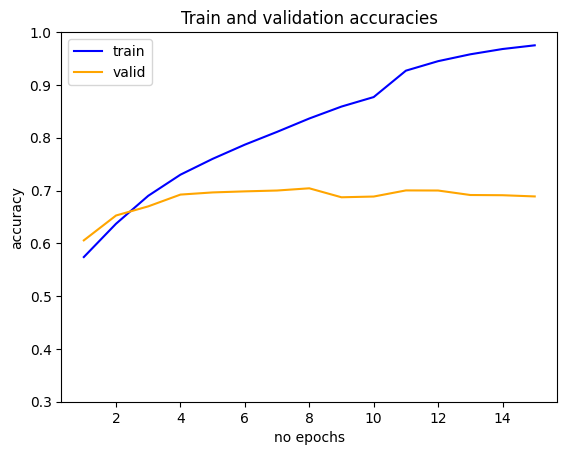

In [9]:
train = [0.574, 0.6371, 0.69, 0.73, 0.76, 0.7869, 0.8111, 0.8364, 0.859, 0.877, 0.927, 0.945, 0.958, 0.968, 0.975 ]
val = [0.6056, 0.6527, 0.67, 0.6923, 0.6964, 0.6984, 0.7, 0.7042, 0.6872, 0.6886, 0.7002, 0.7, 0.6915, 0.6911, 0.6888]

plt.plot(list(range(1, 16)), train, color='blue', label='train')
plt.plot(list(range(1, 16)), val, color='orange', label='valid')
plt.title("Train and validation accuracies")
plt.ylabel("accuracy")
plt.xlabel("no epochs")
plt.ylim((0.3, 1))
plt.legend()

4. Regularization, dropout 